In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


character(0)

In [4]:
#Incluimos las librerías de modelamiento y manejo de datos.
#install.packages('MTS')
#install.packages("devtools")
#install.packages("ardl")
library(devtools)
library(fpp3)
library(urca)
library(vars)
library(quantmod)
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
library(MTS)
library(urca)
library(vars)
library(tsDyn)
library(Metrics)
#library(ardl)

options(warn = - 1) 

Loading required package: usethis

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────── fpp3 1.0.0 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.5
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.1     ✔ feasts      0.3.2
✔ lubridate   1.9.3     ✔ fable       0.3.4
✔ ggplot2     3.5.1     ✔ fabletools  0.4.2

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: struc

In [5]:
# install.packages("MTS_VERSION.tar.gz",repos=NULL,type="source")
library(MTS)

# 1. Descarga de YahooFinance las series de precios de cierre de RYLD, TSLA, TM y GM en las fechas: 22-04-2019 al 31-12-2022.

In [132]:
# Especificamos las fechas de inicio y fin.
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")

#--------- Funcion de obtención de datos, particularmente los datos de precios de cierre.
precio<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interis:
  datos<-datos[,4]
  assign(simbolo, datos, envir = .GlobalEnv)
}

#RYLD, TSLA, TM y GM

In [159]:
# Importemos al ETF del Standard and Poors, el SPY, el índice alemán y el etf del Dow Jhones
precio("RYLD")  # Serie de Global X Russell 2000 Covered Call ETF
precio("TSLA")  # Serie de Tesla
precio("TM") # Serie de Toyota
precio("GM") # Serie de General Motors

##Llamamos por facilidad a nuestros activos:
RYLD= `RYLD`
TSLA=`TSLA`
TM=`TM`
GM=`GM`

# 2. Grafica las series.

In [160]:
## Juntamos los datos, renombramos las columnas y las visualizamos:
prices<-merge.xts(`RYLD`, `TSLA`, `GM`,`TM`,join='inner')%>% na.omit()
dim(prices)
colnames(prices)<-c("RYLD",  "TSLA", "GM", "TM")
dygraph(prices, main = "RYLD, TSLA , GM y TM") %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))

[1] 933   4

HTML widgets cannot be represented in plain text (need html)

# 3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.
### Comprobar que las series son formatos XTS y el índice está en formato Fecha

In [161]:
str(prices)

An xts object on 2019-04-22 / 2022-12-30 containing: 
  Data:    double [933, 4]
  Columns: RYLD, TSLA, GM, TM
  Index:   Date [933] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2025-05-23 03:52:21"


# 4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.



In [162]:
original_prices <- prices
log_prices <- log(prices)
#prices <- prices
head(original_prices)

             RYLD     TSLA    GM     TM
2019-04-22 24.995 17.51667 39.50 124.16
2019-04-23 25.157 17.59333 39.83 124.94
2019-04-24 25.189 17.24400 39.72 122.88
2019-04-25 25.130 16.50867 39.11 123.19
2019-04-26 25.225 15.67600 39.68 123.62
2019-04-29 25.250 16.09800 40.01 123.81

In [164]:
#Partimos serie para train & test
h <- round(nrow(original_prices)*0.05, digits = 0 )
h


or_prices_train <- original_prices[1:(nrow(original_prices) - h), ]
or_prices_test<- original_prices[(nrow(original_prices) - h + 1):nrow(original_prices), ]
or_prices_train
or_prices_test

[1] 47

             RYLD      TSLA    GM     TM
2019-04-22 24.995  17.51667 39.50 124.16
2019-04-23 25.157  17.59333 39.83 124.94
2019-04-24 25.189  17.24400 39.72 122.88
2019-04-25 25.130  16.50867 39.11 123.19
2019-04-26 25.225  15.67600 39.68 123.62
2019-04-29 25.250  16.09800 40.01 123.81
2019-04-30 25.211  15.91267 38.95 123.60
2019-05-01 25.124  15.60067 38.75 122.92
2019-05-02 25.141  16.27333 38.25 122.59
2019-05-03 25.300  17.00200 38.80 123.65
       ...                              
2022-10-11 18.780 216.50000 32.09 135.06
2022-10-12 18.780 217.24001 32.20 135.00
2022-10-13 19.150 221.72000 32.76 136.38
2022-10-14 18.780 204.99001 32.89 134.11
2022-10-17 19.330 219.35001 33.57 136.16
2022-10-18 19.500 220.19000 34.25 134.26
2022-10-19 19.260 222.03999 33.63 132.97
2022-10-20 19.010 207.28000 33.44 133.24
2022-10-21 19.340 214.44000 35.00 133.76
2022-10-24 19.180 211.25000 35.72 134.74

            RYLD   TSLA    GM     TM
2022-10-25 19.35 222.42 37.01 137.07
2022-10-26 19.41 224.64 37.86 137.93
2022-10-27 19.45 225.09 38.16 136.47
2022-10-28 19.56 228.52 38.85 139.52
2022-10-31 19.58 227.54 39.25 138.81
2022-11-01 19.58 227.82 39.35 135.16
2022-11-02 19.49 214.98 38.52 135.39
2022-11-03 19.46 215.31 38.51 135.25
2022-11-04 19.55 207.47 39.00 137.35
2022-11-07 19.61 197.08 39.39 137.26
2022-11-08 19.63 191.30 39.05 137.50
2022-11-09 19.55 177.59 38.06 134.53
2022-11-10 19.70 190.72 39.74 140.52
2022-11-11 19.71 195.97 41.12 143.26
2022-11-14 19.70 190.95 39.93 142.12
2022-11-15 19.70 194.42 40.24 143.75
2022-11-16 19.71 186.92 38.47 142.12
2022-11-17 19.73 183.17 38.64 142.93
2022-11-18 19.47 180.19 39.77 143.19
2022-11-21 19.21 167.87 39.52 142.16
2022-11-22 19.37 169.91 39.97 145.33
2022-11-23 19.43 183.20 40.11 146.71
2022-11-25 19.46 182.86 40.46 148.27
2022-11-28 19.27 182.92 39.38 146.51
2022-11-29 19.34 180.83 39.75 145.40
2022-11-30 19.56 194.70 40.56 147.69
2

### Diferenciación de las series

In [165]:
#Identificamos el nivel regresivo, mediante la función VARselect
adf.test(original_prices[,"RYLD"])
adf.test(original_prices[,"TSLA"])
adf.test(original_prices[,"TM"])
adf.test(original_prices[,"GM"])


	Augmented Dickey-Fuller Test

data:  original_prices[, "RYLD"]
Dickey-Fuller = -1.9681, Lag order = 9, p-value = 0.5918
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  original_prices[, "TSLA"]
Dickey-Fuller = -0.82177, Lag order = 9, p-value = 0.9597
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  original_prices[, "TM"]
Dickey-Fuller = -1.3187, Lag order = 9, p-value = 0.8667
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  original_prices[, "GM"]
Dickey-Fuller = -1.3763, Lag order = 9, p-value = 0.8423
alternative hypothesis: stationary


Las series son no estacionarias, se realiza diferenciación.

In [166]:
diff_prices <- diff(original_prices)
diff_prices <- na.omit(diff_prices)


adf.test(diff_prices[,"RYLD"])
adf.test(diff_prices[,"TSLA"])
adf.test(diff_prices[,"TM"])
adf.test(diff_prices[,"GM"])



	Augmented Dickey-Fuller Test

data:  diff_prices[, "RYLD"]
Dickey-Fuller = -8.0814, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff_prices[, "TSLA"]
Dickey-Fuller = -9.2478, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff_prices[, "TM"]
Dickey-Fuller = -10.768, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff_prices[, "GM"]
Dickey-Fuller = -9.895, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Las series ya son estacionarias

## Modelamiento con Librería VARS


In [168]:
#Selección de orden regresivo
nivelk=VARselect(diff_prices, lag.max = 7, type = "const")
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2

Los resultados muestran que el orden de rezago recomendado es 2

In [169]:
#Partimos serie para train & test
h <- round(nrow(diff_prices)*0.05, digits = 0 )
h


prices_train <- diff_prices[1:(nrow(diff_prices) - h), ]
prices_test<- diff_prices[(nrow(diff_prices) - h + 1):nrow(diff_prices), ]
prices_train
prices_test

[1] 47

                   RYLD         TSLA         GM          TM
2019-04-23  0.161998749   0.07666588  0.3300018  0.77999878
2019-04-24  0.031999588  -0.34933281 -0.1100006 -2.06000519
2019-04-25 -0.059000015  -0.73533249 -0.6100006  0.31000519
2019-04-26  0.095001221  -0.83266735  0.5699997  0.43000031
2019-04-29  0.024999619   0.42199993  0.3299980  0.18999481
2019-04-30 -0.038999557  -0.18533230 -1.0599976 -0.20999908
2019-05-01 -0.086999893  -0.31200027 -0.2000008 -0.68000031
2019-05-02  0.017000198   0.67266560 -0.5000000 -0.33000183
2019-05-03  0.158998489   0.72866821  0.5499992  1.06000519
2019-05-06 -0.004999161   0.02066612 -0.7099991 -0.66999817
       ...                                                 
2022-10-11 -0.069999695  -6.46000671 -0.2000008  0.19999695
2022-10-12  0.000000000   0.74000549  0.1100006 -0.05999756
2022-10-13  0.369998932   4.47999573  0.5599976  1.38000488
2022-10-14 -0.369998932 -16.72999573  0.1300011 -2.27000427
2022-10-17  0.549999237  14.36000061  0.

                   RYLD         TSLA          GM          TM
2022-10-25  0.170000076  11.16999817  1.28999710  2.33000183
2022-10-26  0.059999466   2.22000122  0.85000229  0.85998535
2022-10-27  0.040000916   0.44999695  0.29999924 -1.45999146
2022-10-28  0.109998703   3.43000793  0.68999863  3.05000305
2022-10-31  0.020000458  -0.98001099  0.40000153 -0.71000671
2022-11-01  0.000000000   0.28001404  0.09999847 -3.64999390
2022-11-02 -0.090000153 -12.84001160 -0.82999802  0.22999573
2022-11-03 -0.030000687   0.33000183 -0.01000214 -0.13999939
2022-11-04  0.090000153  -7.83999634  0.49000168  2.10000610
2022-11-07  0.060001373 -10.38999939  0.38999939 -0.09001160
2022-11-08  0.019998550  -5.77999878 -0.34000015  0.24000549
2022-11-09 -0.079999924 -13.71000671 -0.98999786 -2.97000122
2022-11-10  0.150001526  13.13000488  1.68000031  5.99000549
2022-11-11  0.009998322   5.25000000  1.37999725  2.73999023
2022-11-14 -0.009998322  -5.02000427 -1.18999863 -1.13999939
2022-11-15  0.000000000 

In [231]:
#Regresion VAR con datos de entrenamieto

m0=vars::VAR(prices_train, p=2)
summary(m0)


VAR Estimation Results:
Endogenous variables: RYLD, TSLA, GM, TM 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = prices_train, p = 2)


Estimation results for equation RYLD: 
RYLD = RYLD.l1 + TSLA.l1 + GM.l1 + TM.l1 + RYLD.l2 + TSLA.l2 + GM.l2 + TM.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
RYLD.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
TSLA.l1  0.0003732  0.0011952   0.312  0.75490    
GM.l1    0.0152832  0.0104306   1.465  0.14322    
TM.l1   -0.0017988  0.0046631  -0.386  0.69977    
RYLD.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
TSLA.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
GM.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
TM.l2   -0.0001906  0.0046566  -0.041  0.96736    
const   -0.0054134  0.0088864  -0.609  0.54256    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual st

## Modelamiento con Librería MTS

In [232]:
# Selección del orden regresivo
VARorder(diff_prices) 

selected order: aic =  2 
selected order: bic =  0 
selected order: hq =  2 
Summary table:  
       p    AIC    BIC     HQ    M(p) p-value
 [1,]  0 2.4738 2.4738 2.4738  0.0000  0.0000
 [2,]  1 2.4539 2.5369 2.4856 49.5841  0.0000
 [3,]  2 2.4059 2.5720 2.4692 74.9077  0.0000
 [4,]  3 2.4311 2.6802 2.5261  8.2821  0.9400
 [5,]  4 2.4365 2.7687 2.5632 26.0077  0.0539
 [6,]  5 2.4510 2.8663 2.6094 17.8070  0.3353
 [7,]  6 2.4647 2.9629 2.6547 18.5089  0.2949
 [8,]  7 2.4577 3.0390 2.6793 36.7762  0.0023
 [9,]  8 2.4651 3.1294 2.7184 23.8195  0.0935
[10,]  9 2.4620 3.2094 2.7471 32.9700  0.0075
[11,] 10 2.4752 3.3056 2.7919 18.5853  0.2908
[12,] 11 2.4854 3.3989 2.8338 21.0232  0.1776
[13,] 12 2.5054 3.5019 2.8854 12.5226  0.7073
[14,] 13 2.5261 3.6057 2.9379 11.7476  0.7612


Por simplicidad del modelo, se selecciona p=2 dado que en el rezago 3 ya se evidencia un salto en el p-valor

In [233]:
#Ahora, aplicamos la función de VAR, para generar el modelo de regresión:
m1=MTS::VAR(as.matrix(prices_train),2)

Constant term: 
Estimates:  -0.005413425 0.2545003 -0.001985235 0.007388606 
Std.Error:  0.008886438 0.2742414 0.03683012 0.07765216 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]      [,2]     [,3]    [,4]
[1,] -0.1405  0.000373  0.01528 -0.0018
[2,]  1.2525 -0.043873 -0.35200 -0.0131
[3,] -0.0555  0.009925 -0.00975 -0.0102
[4,] -1.0907  0.014009  0.09280  0.0122
standard error 
       [,1]    [,2]   [,3]    [,4]
[1,] 0.0427 0.00120 0.0104 0.00466
[2,] 1.3184 0.03688 0.3219 0.14391
[3,] 0.1771 0.00495 0.0432 0.01933
[4,] 0.3733 0.01044 0.0911 0.04075
AR( 2 )-matrix 
      [,1]     [,2]    [,3]      [,4]
[1,] 0.286 -0.00234 -0.0206 -0.000191
[2,] 2.394 -0.01228 -0.0696 -0.016173
[3,] 0.442 -0.00867 -0.0179 -0.032857
[4,] 0.243 -0.00693  0.1269  0.012395
standard error 
       [,1]    [,2]   [,3]    [,4]
[1,] 0.0429 0.00120 0.0104 0.00466
[2,] 1.3230 0.03689 0.3213 0.14371
[3,] 0.1777 0.00495 0.0431 0.01930
[4,] 0.3746 0.01045 0.0910 0.04069
  
Residuals cov-mtx: 
           [,1] 

Ljung-Box Statistics:  
          m       Q(m)     df    p-value
 [1,]   1.000     0.193 -20.000     1.00
 [2,]   2.000     0.890  -4.000     1.00
 [3,]   3.000     6.124  12.000     1.00
 [4,]   4.000    32.267  28.000     0.26
 [5,]   5.000    49.949  44.000     0.25
 [6,]   6.000    66.022  60.000     0.28
 [7,]   7.000    99.954  76.000     0.03
 [8,]   8.000   126.774  92.000     0.01
 [9,]   9.000   167.835 108.000     0.00
[10,]  10.000   183.934 124.000     0.00
[11,]  11.000   203.825 140.000     0.00
[12,]  12.000   215.183 156.000     0.00
[13,]  13.000   226.861 172.000     0.00
[14,]  14.000   250.189 188.000     0.00
[15,]  15.000   274.746 204.000     0.00
[16,]  16.000   292.363 220.000     0.00
[17,]  17.000   315.377 236.000     0.00
[18,]  18.000   337.159 252.000     0.00
[19,]  19.000   379.438 268.000     0.00
[20,]  20.000   388.513 284.000     0.00
[21,]  21.000   402.650 300.000     0.00
[22,]  22.000   415.505 316.000     0.00
[23,]  23.000   434.643 332.000  

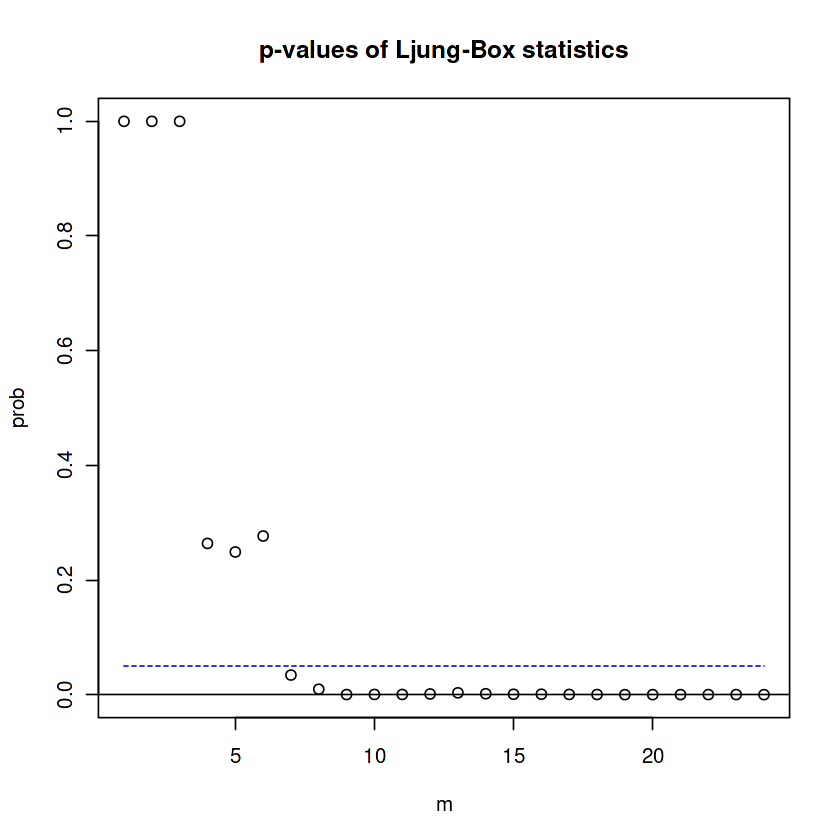

In [234]:
resi=m1$residuals
mq(resi, adj=36)

In [235]:
m2=refVAR(m1,thres = 1.96)

Constant term: 
Estimates:  0 0 0 0 
Std.Error:  0 0 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1] [,2] [,3] [,4]
[1,] -0.110    0    0    0
[2,]  0.000    0    0    0
[3,]  0.000    0    0    0
[4,] -0.712    0    0    0
standard error 
       [,1] [,2] [,3] [,4]
[1,] 0.0329    0    0    0
[2,] 0.0000    0    0    0
[3,] 0.0000    0    0    0
[4,] 0.2832    0    0    0
AR( 2 )-matrix 
      [,1]     [,2]    [,3]    [,4]
[1,] 0.272  0.00000 -0.0243  0.0000
[2,] 0.000  0.00000  0.0000  0.0000
[3,] 0.439 -0.00962  0.0000 -0.0361
[4,] 0.000  0.00000  0.1554  0.0000
standard error 
       [,1]   [,2]    [,3]   [,4]
[1,] 0.0396 0.0000 0.00979 0.0000
[2,] 0.0000 0.0000 0.00000 0.0000
[3,] 0.1612 0.0049 0.00000 0.0183
[4,] 0.0000 0.0000 0.07076 0.0000
  
Residuals cov-mtx: 
                      resi                    
     0.06916046  0.7964633 0.1612436 0.2955452
resi 0.79646333 65.9615077 2.6771854 4.8661707
     0.16124361  2.6771854 1.1854212 1.2711235
     0.29554517  4.86617

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      17.8    -5.0     1.00
 [2,]   2.0      29.5    11.0     1.00
 [3,]   3.0      35.0    27.0     0.14
 [4,]   4.0      61.1    43.0     0.04
 [5,]   5.0      76.7    59.0     0.06
 [6,]   6.0      92.3    75.0     0.09
 [7,]   7.0     127.5    91.0     0.01
 [8,]   8.0     157.3   107.0     0.00
 [9,]   9.0     199.8   123.0     0.00
[10,]  10.0     216.8   139.0     0.00
[11,]  11.0     236.4   155.0     0.00
[12,]  12.0     248.0   171.0     0.00
[13,]  13.0     260.6   187.0     0.00
[14,]  14.0     284.8   203.0     0.00
[15,]  15.0     309.6   219.0     0.00
[16,]  16.0     327.2   235.0     0.00
[17,]  17.0     352.2   251.0     0.00
[18,]  18.0     373.5   267.0     0.00
[19,]  19.0     417.2   283.0     0.00
[20,]  20.0     425.9   299.0     0.00
[21,]  21.0     439.9   315.0     0.00
[22,]  22.0     452.4   331.0     0.00
[23,]  23.0     472.4   347.0     0.00
[24,]  24.0     507.7   363.0     0.00


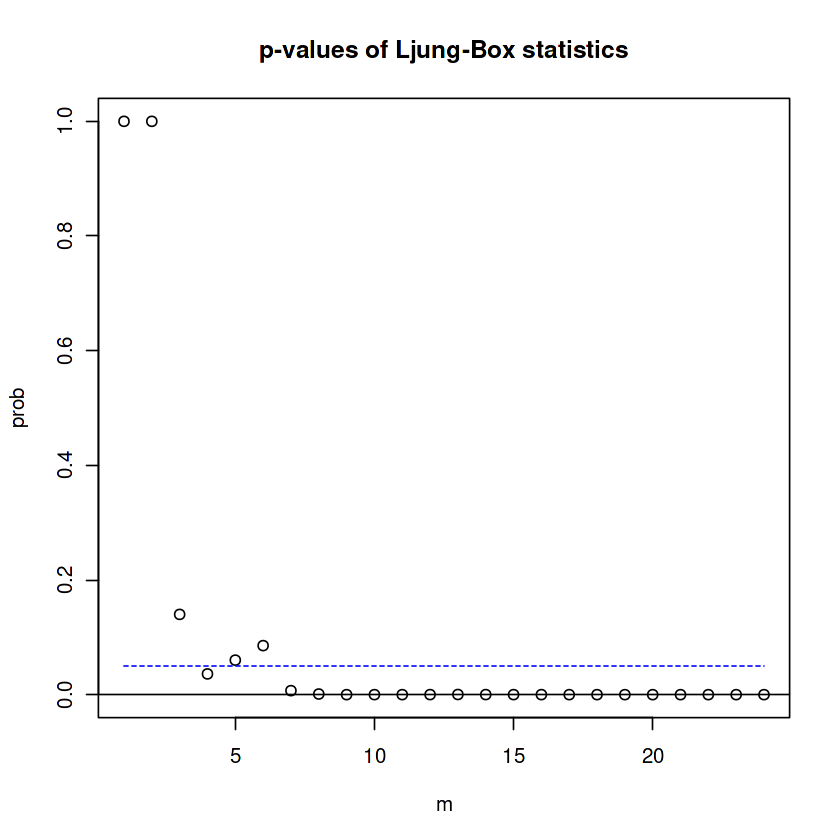

In [236]:
resi=m2$residuals
mq(resi, adj=21)

### Análisis Impulso-Respuesta

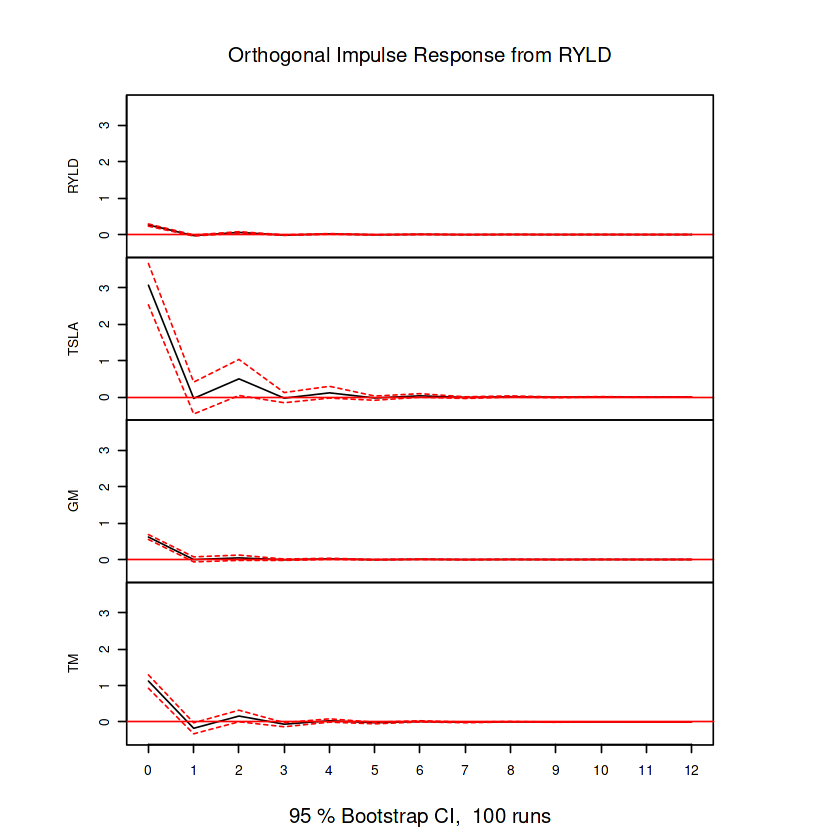

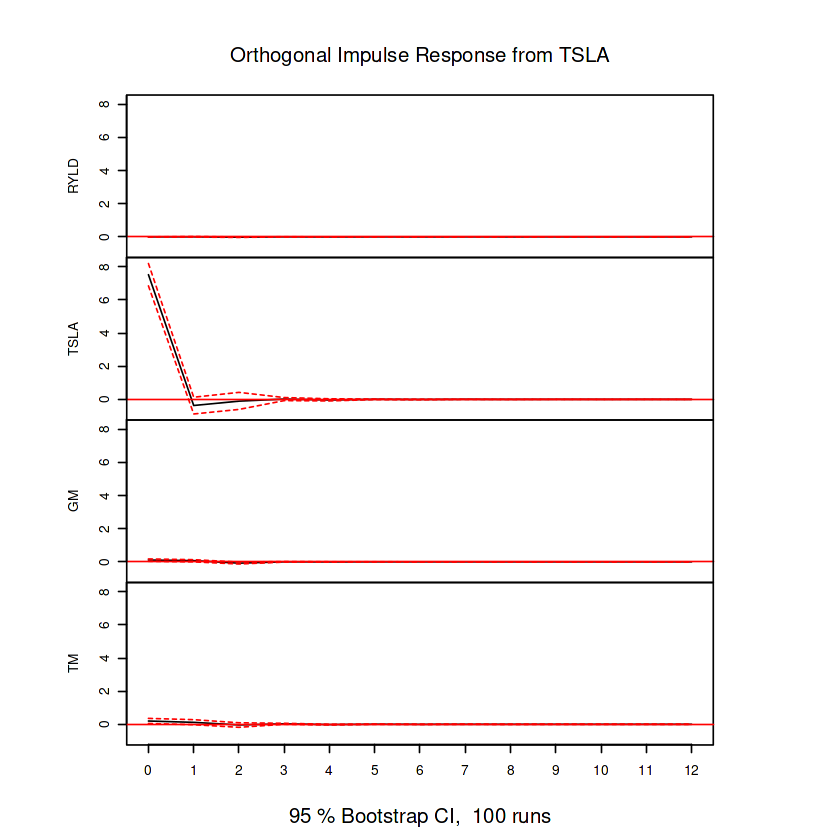

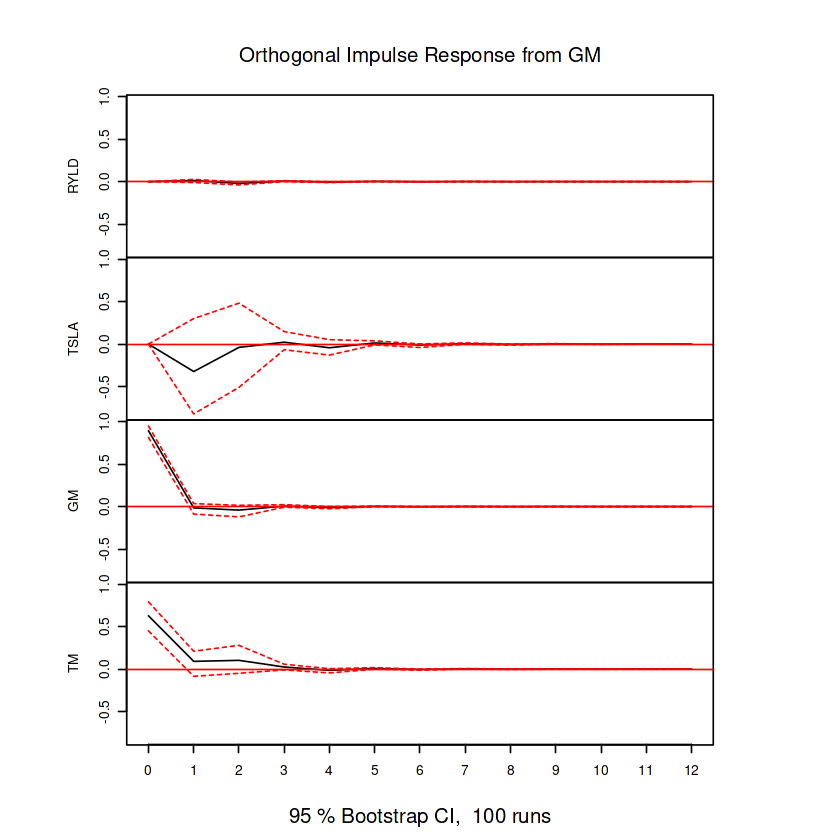

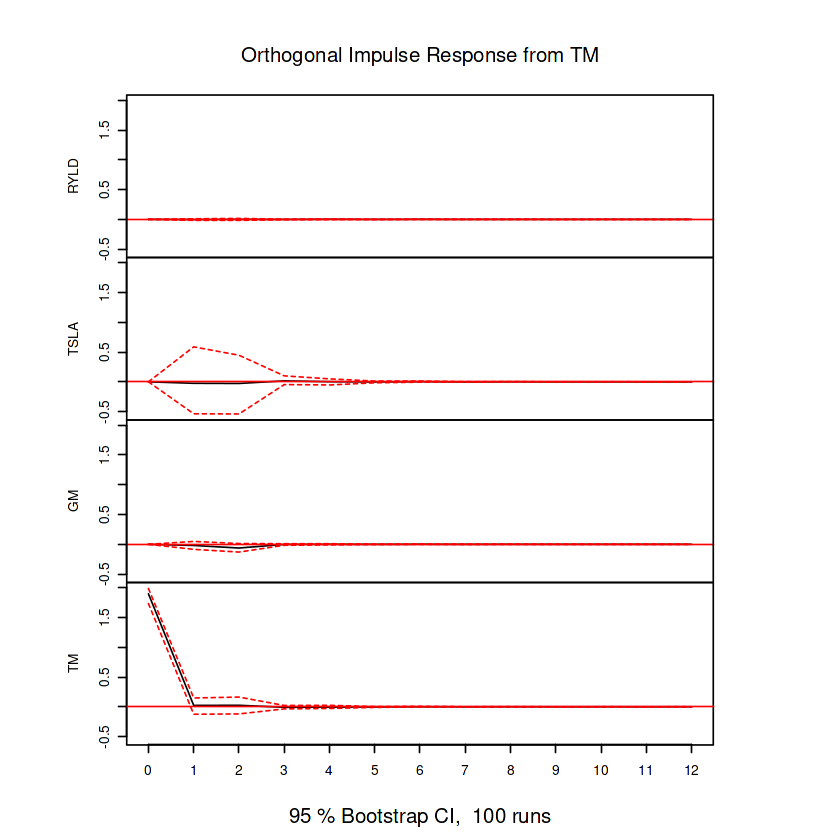

In [237]:
# La función de impulso respuesta se lleva a cabo mediante la librería de vars. La función es la irf(). Apliquemos la función al primer modelo.
m1irf = irf(m0, n.ahead = 12, boot = TRUE)
plot(m1irf) 

## Evaluación con set de pruebas y cálculo de métricas

In [246]:
h1 <- nrow(prices_test)

# Obtener pronóstico para m2
var_pred_m2 = VARpred(m2, h1)  

orig  885 
Forecasts at origin:  885 
       RYLD TSLA         GM         TM
  6.961e-02    0  5.704e-02  3.564e-01
 -6.868e-02    0 -7.487e-02  6.232e-02
  2.511e-02    0  1.765e-02  5.778e-02
 -1.965e-02    0 -3.237e-02 -2.952e-02
  8.568e-03    0  8.925e-03  1.674e-02
 -5.508e-03    0 -7.550e-03 -1.113e-02
  2.722e-03    0  3.152e-03  5.310e-03
 -1.616e-03    0 -2.013e-03 -3.112e-03
  8.422e-04    0  1.002e-03  1.641e-03
 -4.837e-04    0 -5.961e-04 -9.127e-04
  2.582e-04    0  3.100e-04  5.002e-04
 -1.456e-04    0 -1.791e-04 -2.765e-04
  7.879e-05    0  9.515e-05  1.519e-04
 -4.397e-05    0 -5.387e-05 -8.396e-05
  2.398e-05    0  2.906e-05  4.610e-05
 -1.330e-05    0 -1.625e-05 -2.545e-05
  7.286e-06    0  8.849e-06  1.399e-05
 -4.028e-06    0 -4.913e-06 -7.715e-06
  2.212e-06    0  2.690e-06  4.245e-06
 -1.221e-06    0 -1.488e-06 -2.339e-06
  6.713e-07    0  8.167e-07  1.288e-06
 -3.701e-07    0 -4.509e-07 -7.094e-07
  2.037e-07    0  2.478e-07  3.906e-07
 -1.122e-07    0 -1.367e-0

Se debe reconstruir la serie sin diferenciación tener la predicción real de los precios y no solo las diferencias

In [247]:
ult_real_train <- as.numeric(tail(or_prices_train$RYLD,1))
pred_precio_ryld_m2_var <- cumsum(c(ult_real_train,var_pred_m2$pred[,"RYLD"]))[-1]

pred_precio_ryld_m2_var #Predicción reconstruida a valores de precio real, este será y_pred para calcular métricas

19.24961 19.18093 19.20604 19.18639 19.19496 19.18945 19.19218 19.19056 
                                                                        
19.19140 19.19092 19.19118 19.19103 19.19111 19.19107 19.19109 19.19108 
                                                                        
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 
                                                                        
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 
                                                                        
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 
                                                               
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108

In [248]:
as.numeric(or_prices_test$RYLD)
#str(pred_precio_ryld_m2_var)

[1] 19.35 19.41 19.45 19.56 19.58 19.58 19.49 19.46 19.55 19.61 19.63 19.55
[13] 19.70 19.71 19.70 19.70 19.71 19.73 19.47 19.21 19.37 19.43 19.46 19.27
[25] 19.34 19.56 19.60 19.64 19.42 19.25 19.20 19.31 19.16 19.30 19.49 19.47
[37] 19.02 18.88 18.75 18.84 19.00 18.90 18.95 18.92 18.78 18.84 18.81

In [249]:
y_test = as.numeric(or_prices_test$RYLD)
y_pred = pred_precio_ryld_m2_var


RMSE_VAR = rmse(y_test,y_pred)
MAE_VAR = mae(y_test,y_pred)
MAPE_VAR = mape(y_test,y_pred)


RMSE_VAR
MAE_VAR
MAPE_VAR


[1] 0.3298093

[1] 0.2968814

[1] 0.0153113

# Modelación con ARDL

In [250]:
# Actualizamos la versión de R en Kaggle, así como algunas versiones de depaendencias de la paquetería ARDL. Este proceso es tardado.
#install.packages("CCA")
#devtools::install_version("pbkrtest", version = "0.5.1")

#install.packages("devtools")
#devtools::install_github("Natsiopoulos/ARDL")

### Para el modelado
library(ARDL)

Para ARDL no se usará la serie diferenciada pero si aplicando Log

In [251]:
#prices ya tiene las variables con log, pero sin diferenciar
head(original_prices)

             RYLD     TSLA    GM     TM
2019-04-22 24.995 17.51667 39.50 124.16
2019-04-23 25.157 17.59333 39.83 124.94
2019-04-24 25.189 17.24400 39.72 122.88
2019-04-25 25.130 16.50867 39.11 123.19
2019-04-26 25.225 15.67600 39.68 123.62
2019-04-29 25.250 16.09800 40.01 123.81

Dividir en Train y Test

In [252]:
#Partimos serie para train & test
h <- round(nrow(original_prices)*0.05, digits = 0 )
h


prices_train_ARDL <- original_prices[1:(nrow(original_prices) - h), ]
prices_test_ARDL<- original_prices[(nrow(original_prices) - h + 1):nrow(original_prices), ]
prices_train_ARDL
prices_test_ARDL

[1] 47

             RYLD      TSLA    GM     TM
2019-04-22 24.995  17.51667 39.50 124.16
2019-04-23 25.157  17.59333 39.83 124.94
2019-04-24 25.189  17.24400 39.72 122.88
2019-04-25 25.130  16.50867 39.11 123.19
2019-04-26 25.225  15.67600 39.68 123.62
2019-04-29 25.250  16.09800 40.01 123.81
2019-04-30 25.211  15.91267 38.95 123.60
2019-05-01 25.124  15.60067 38.75 122.92
2019-05-02 25.141  16.27333 38.25 122.59
2019-05-03 25.300  17.00200 38.80 123.65
       ...                              
2022-10-11 18.780 216.50000 32.09 135.06
2022-10-12 18.780 217.24001 32.20 135.00
2022-10-13 19.150 221.72000 32.76 136.38
2022-10-14 18.780 204.99001 32.89 134.11
2022-10-17 19.330 219.35001 33.57 136.16
2022-10-18 19.500 220.19000 34.25 134.26
2022-10-19 19.260 222.03999 33.63 132.97
2022-10-20 19.010 207.28000 33.44 133.24
2022-10-21 19.340 214.44000 35.00 133.76
2022-10-24 19.180 211.25000 35.72 134.74

            RYLD   TSLA    GM     TM
2022-10-25 19.35 222.42 37.01 137.07
2022-10-26 19.41 224.64 37.86 137.93
2022-10-27 19.45 225.09 38.16 136.47
2022-10-28 19.56 228.52 38.85 139.52
2022-10-31 19.58 227.54 39.25 138.81
2022-11-01 19.58 227.82 39.35 135.16
2022-11-02 19.49 214.98 38.52 135.39
2022-11-03 19.46 215.31 38.51 135.25
2022-11-04 19.55 207.47 39.00 137.35
2022-11-07 19.61 197.08 39.39 137.26
2022-11-08 19.63 191.30 39.05 137.50
2022-11-09 19.55 177.59 38.06 134.53
2022-11-10 19.70 190.72 39.74 140.52
2022-11-11 19.71 195.97 41.12 143.26
2022-11-14 19.70 190.95 39.93 142.12
2022-11-15 19.70 194.42 40.24 143.75
2022-11-16 19.71 186.92 38.47 142.12
2022-11-17 19.73 183.17 38.64 142.93
2022-11-18 19.47 180.19 39.77 143.19
2022-11-21 19.21 167.87 39.52 142.16
2022-11-22 19.37 169.91 39.97 145.33
2022-11-23 19.43 183.20 40.11 146.71
2022-11-25 19.46 182.86 40.46 148.27
2022-11-28 19.27 182.92 39.38 146.51
2022-11-29 19.34 180.83 39.75 145.40
2022-11-30 19.56 194.70 40.56 147.69
2

In [27]:
#install.packages("remotes", repos = "https://cran.r-project.org")
#remotes::install_version("stringi", version = "1.8.3")  # Versión estable conocida

#install.packages("stringi", type = "source")
#install.packages("stringr")
#install.packages("ARDL")

In [253]:
prices_train <- na.omit(prices_train)
data_df <- data.frame(date = index(prices_train_ARDL), coredata(prices_train_ARDL))


In [256]:
models <- auto_ardl(RYLD ~ TSLA +TM + GM, data = data_df, max_order = 6)

In [257]:
models$top_orders

RYLD,TSLA,TM,GM,AIC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,1,3,-307.4130
3,1,2,3,-305.8611
3,2,1,3,-305.5586
3,1,1,4,-304.8608
4,1,1,3,-304.0696
3,2,2,3,-303.9719
4,1,1,4,-303.0162
4,1,2,3,-302.5227
4,2,1,3,-302.2173


In [258]:
modelo_ardl <- ardl(RYLD ~ TSLA +TM + GM, data = data_df ,order = c(3,1,1,3))
summary(modelo_ardl)
modelo_ardl$full_formula


Time series regression with "ts" data:
Start = 4, End = 886

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67649 -0.10110  0.00956  0.11214  0.73684 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.1488489  0.0915044   1.627 0.104165    
L(RYLD, 1)   0.8668074  0.0309039  28.049  < 2e-16 ***
L(RYLD, 2)   0.3373508  0.0390773   8.633  < 2e-16 ***
L(RYLD, 3)  -0.2217836  0.0306534  -7.235 1.02e-12 ***
TSLA         0.0062359  0.0008919   6.992 5.41e-12 ***
L(TSLA, 1)  -0.0066197  0.0008909  -7.430 2.59e-13 ***
TM           0.0274560  0.0034883   7.871 1.04e-14 ***
L(TM, 1)    -0.0262163  0.0035202  -7.447 2.29e-13 ***
GM           0.0944349  0.0074301  12.710  < 2e-16 ***
L(GM, 1)    -0.0781005  0.0104085  -7.504 1.53e-13 ***
L(GM, 2)    -0.0346547  0.0103583  -3.346 0.000856 ***
L(GM, 3)     0.0214165  0.0075761   2.827 0.004809 ** 
---
Signif. codes

RYLD ~ L(RYLD, 1) + L(RYLD, 2) + L(RYLD, 3) + TSLA + L(TSLA, 
    1) + TM + L(TM, 1) + GM + L(GM, 1) + L(GM, 2) + L(GM, 3)

### Cálculo de métricas usando la serie de RYLD

In [262]:
m_ardl_pred = predict(modelo_ardl$fitted.values, h=h1)

y_pred = as.numeric(m_ardl_pred$mean)
y_test = as.numeric(prices_test_ARDL$RYLD)

In [266]:
RMSE_ARDL = rmse(y_test, y_pred)
MAE_ARDL = mae(y_test, y_pred)
MAPE_ARDL = mape(y_test, y_pred)

In [271]:
RMSE_ARDL
MAE_ARDL
MAPE_ARDL

[1] 0.3059226

[1] 0.2400017

[1] 0.01251865

In [274]:
modelo <- models$best_model

### Dados los resultados de RMSE, MAE y MAPE el modelo seleccionado es ARDL, con este se realiza el pronóstico de 10 días


    Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
887       19.36144 19.04478 19.67810 18.87714 19.84574
888       19.37379 18.90386 19.84373 18.65509 20.09250
889       19.38368 18.78451 19.98284 18.46734 20.30002
890       19.39158 18.67598 20.10719 18.29716 20.48601
891       19.39791 18.57469 20.22113 18.13890 20.65691
892       19.40297 18.47904 20.32690 17.98994 20.81599
893       19.40702 18.38814 20.42589 17.84878 20.96525
894       19.41025 18.30141 20.51909 17.71443 21.10608
895       19.41284 18.21844 20.60725 17.58616 21.23953
896       19.41492 18.13889 20.69095 17.46340 21.36644

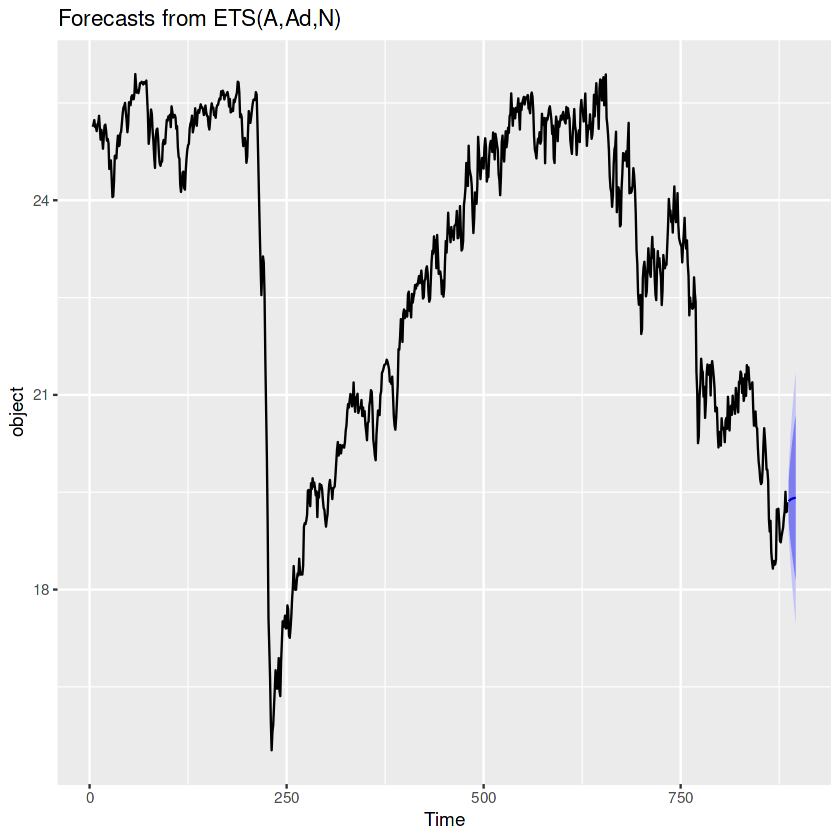

In [279]:
stats::predict(modelo_ardl$fitted.values, h=10)
autoplot(predict(modelo_ardl$fitted.values, h=10))

In [275]:
bounds_f_test(modelo, case = 2) # el parametro "case" igual a 2 verifica si existe relaciones a largo termino, con la combinación de (restricted constant, no linear trend).


	Bounds F-test (Wald) for no cointegration

data:  d(RYLD) ~ L(RYLD, 1) + L(TSLA, 1) + L(TM, 1) + L(GM, 1) + d(L(RYLD,     1)) + d(L(RYLD, 2)) + d(TSLA) + d(TM) + d(GM) + d(L(GM, 1)) +     d(L(GM, 2))
F = 2.5919, p-value = 0.2228
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


In [276]:
#Multiplicadores a corto plazo
multipliers(modelo, type = "sr")

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),0.148848875,0.0915043640,1.626686,1.041655e-01
2,TSLA,0.006235931,0.0008919174,6.991602,5.408892e-12
3,TM,0.027456034,0.0034882965,7.870900,1.043152e-14
4,GM,0.094434868,0.0074301356,12.709710,4.508574e-34


In [277]:
#Multiplicadores a largo plazo
multipliers(modelo)

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),8.44514390,4.021866309,2.099807,0.0360329457
2,TSLA,-0.02177608,0.005783516,-3.765197,0.0001775872
3,TM,0.07034011,0.037839392,1.858912,0.0633766642
4,GM,0.17566844,0.054624276,3.215941,0.0013481119
